# Convolutional Neural Network for Aerial Cactus Identification
This notebook demonstrates training a CNN model to classify aerial images of terrain as containing a cactus or not. Key steps include:
- Loading and preprocessing training images
- Defining CNN model architecture  
- Training model with data augmentation
- Evaluating model performance
- Making predictions on test images

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall

2024-04-29 16:42:53.363934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 16:42:53.364044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 16:42:53.505500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def prepareImages(data, m, dataset, i=150, j=150, depth=1):
    """Load images and convert to numpy array.
    
    Args:
        data (DataFrame): Contains image ids to load.
        m (int): Number of images. 
        dataset (str): Path to image directory.
        i (int): Target image width.
        j (int): Target image height.  
        depth (int): Color channels (1 for grayscale, 3 for RGB).

    Returns:
        numpy.array: Images loaded into array of shape (m, i, j, depth).
    """
    print(f"Preparing {m} images from {dataset} directory, resized to {i}x{j}...")
    X = np.zeros((m, i, j, depth))
    for idx, image_id in enumerate(data['id']):
        img = Image.open(f"{dataset}/{image_id}").resize((i, j))
        if depth == 1:
            img = img.convert('L')
        X[idx] = np.array(img)
        if idx % 500 == 0:
            print(f"Loaded {idx+1}/{m} images")
    return X

In [3]:
def add_conv_block(model, filters, size, stride, padding='same'):
    """Add a convolutional block to the model"""
    model = Conv2D(filters, size, strides=stride, padding=padding, activation='relu')(model)
    model = MaxPooling2D(pool_size=2)(model) 
    model = BatchNormalization(axis=3)(model)
    model = Dropout(0.2)(model)
    return model

def build_model(input_shape, num_classes):
    """Define model architecture"""
    print(f"Building model for input shape {input_shape} and {num_classes} classes")
    inputs = Input(shape=input_shape)
    
    model = BatchNormalization(axis=3)(inputs)
    
    model = add_conv_block(model, 48, 5, 1)
    model = add_conv_block(model, 64, 5, 1)  
    model = add_conv_block(model, 128, 5, 1)
    model = add_conv_block(model, 160, 5, 1)
    model = add_conv_block(model, 192, 5, 1)

    model = Flatten()(model)
    outputs = Dense(num_classes, activation='sigmoid')(model)
    
    return Model(inputs=inputs, outputs=outputs)

In [4]:
def plot_history(history):
    """Plot training history"""
    print("Training history:")
    for metric, values in history.items():
        if not metric.startswith('val_'):
            print(f"{metric}: min={min(values):.4f}, max={max(values):.4f}")
            
    metrics = list(history.keys())
    num_metrics = len(metrics) // 2 + 1
    num_cols = 3
    num_rows = (num_metrics + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 16))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        if not metric.startswith('val_'):
            ax = axes[i]
            ax.plot(history[metric], marker='o')
            if metric != 'lr':
                ax.plot(history[f'val_{metric}'], marker='o')
            ax.set_title(metric)
            ax.set_xlabel('Epoch')
            ax.legend(['Train', 'Val'], loc='upper right')
            ax.grid()

In [5]:
# Load training data
train_df = pd.read_csv("train.csv")
width, height, depth = 32, 32, 3
num_classes = 1
batch_size = 16
epochs = 50

In [6]:
# Build model
model = build_model((width, height, depth), num_classes)
model.summary()

Building model for input shape (32, 32, 3) and 1 classes


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 48)     │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 160)      │       512,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 160)      │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 192)      │       768,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 192)      │             

 Total params: 1,568,365 (5.98 MB)

 Trainable params: 1,567,175 (5.98 MB)

 Non-trainable params: 1,190 (4.65 KB)

In [7]:
# Load and preprocess images  
X = prepareImages(train_df, train_df.shape[0], "train/train", width, height, depth)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, train_df['has_cactus'], test_size=0.1, random_state=4)

Preparing 17500 images from aerial-cactus/train/train directory, resized to 32x32...
Loaded 1/17500 images
Loaded 501/17500 images
Loaded 1001/17500 images
Loaded 1501/17500 images
Loaded 2001/17500 images
Loaded 2501/17500 images
Loaded 3001/17500 images
Loaded 3501/17500 images
Loaded 4001/17500 images
Loaded 4501/17500 images
Loaded 5001/17500 images
Loaded 5501/17500 images
Loaded 6001/17500 images
Loaded 6501/17500 images
Loaded 7001/17500 images
Loaded 7501/17500 images
Loaded 8001/17500 images
Loaded 8501/17500 images
Loaded 9001/17500 images
Loaded 9501/17500 images
Loaded 10001/17500 images
Loaded 10501/17500 images
Loaded 11001/17500 images
Loaded 11501/17500 images
Loaded 12001/17500 images
Loaded 12501/17500 images
Loaded 13001/17500 images
Loaded 13501/17500 images
Loaded 14001/17500 images
Loaded 14501/17500 images
Loaded 15001/17500 images
Loaded 15501/17500 images
Loaded 16001/17500 images
Loaded 16501/17500 images
Loaded 17001/17500 images


In [8]:
# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Set up data augmentation 
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
aug.fit(X_train)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 16/985 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - auc: 0.8264 - loss: 0.6175 - precision: 0.8804 - recall: 0.6488

I0000 00:00:1714409091.354887      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


985/985 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - auc: 0.9324 - loss: 0.2962 - precision: 0.9318 - recall: 0.9165 - val_auc: 0.9954 - val_loss: 0.1129 - val_precision: 0.9521 - val_recall: 0.9963
Epoch 2/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - auc: 0.9794 - loss: 0.1552 - precision: 0.9572 - recall: 0.9660 - val_auc: 0.9996 - val_loss: 0.0439 - val_precision: 0.9795 - val_recall: 0.9993
Epoch 3/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - auc: 0.9865 - loss: 0.1226 - precision: 0.9699 - recall: 0.9737 - val_auc: 0.9978 - val_loss: 0.0739 - val_precision: 0.9694 - val_recall: 0.9940
Epoch 4/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - auc: 0.9912 - loss: 0.0991 - precision: 0.9742 - recall: 0.9762 - val_auc: 0.9997 - val_loss: 0.0282 - val_precision: 0.9859 - val_recall: 0.9970
Epoch 5/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - auc: 0.9920 - loss: 0.0865 - precision: 0.9785 - recall: 0.9821 - val_auc: 0.9997 - val_loss: 0.0187 - val_precision: 0.9978 - val_recall: 0.9978
E

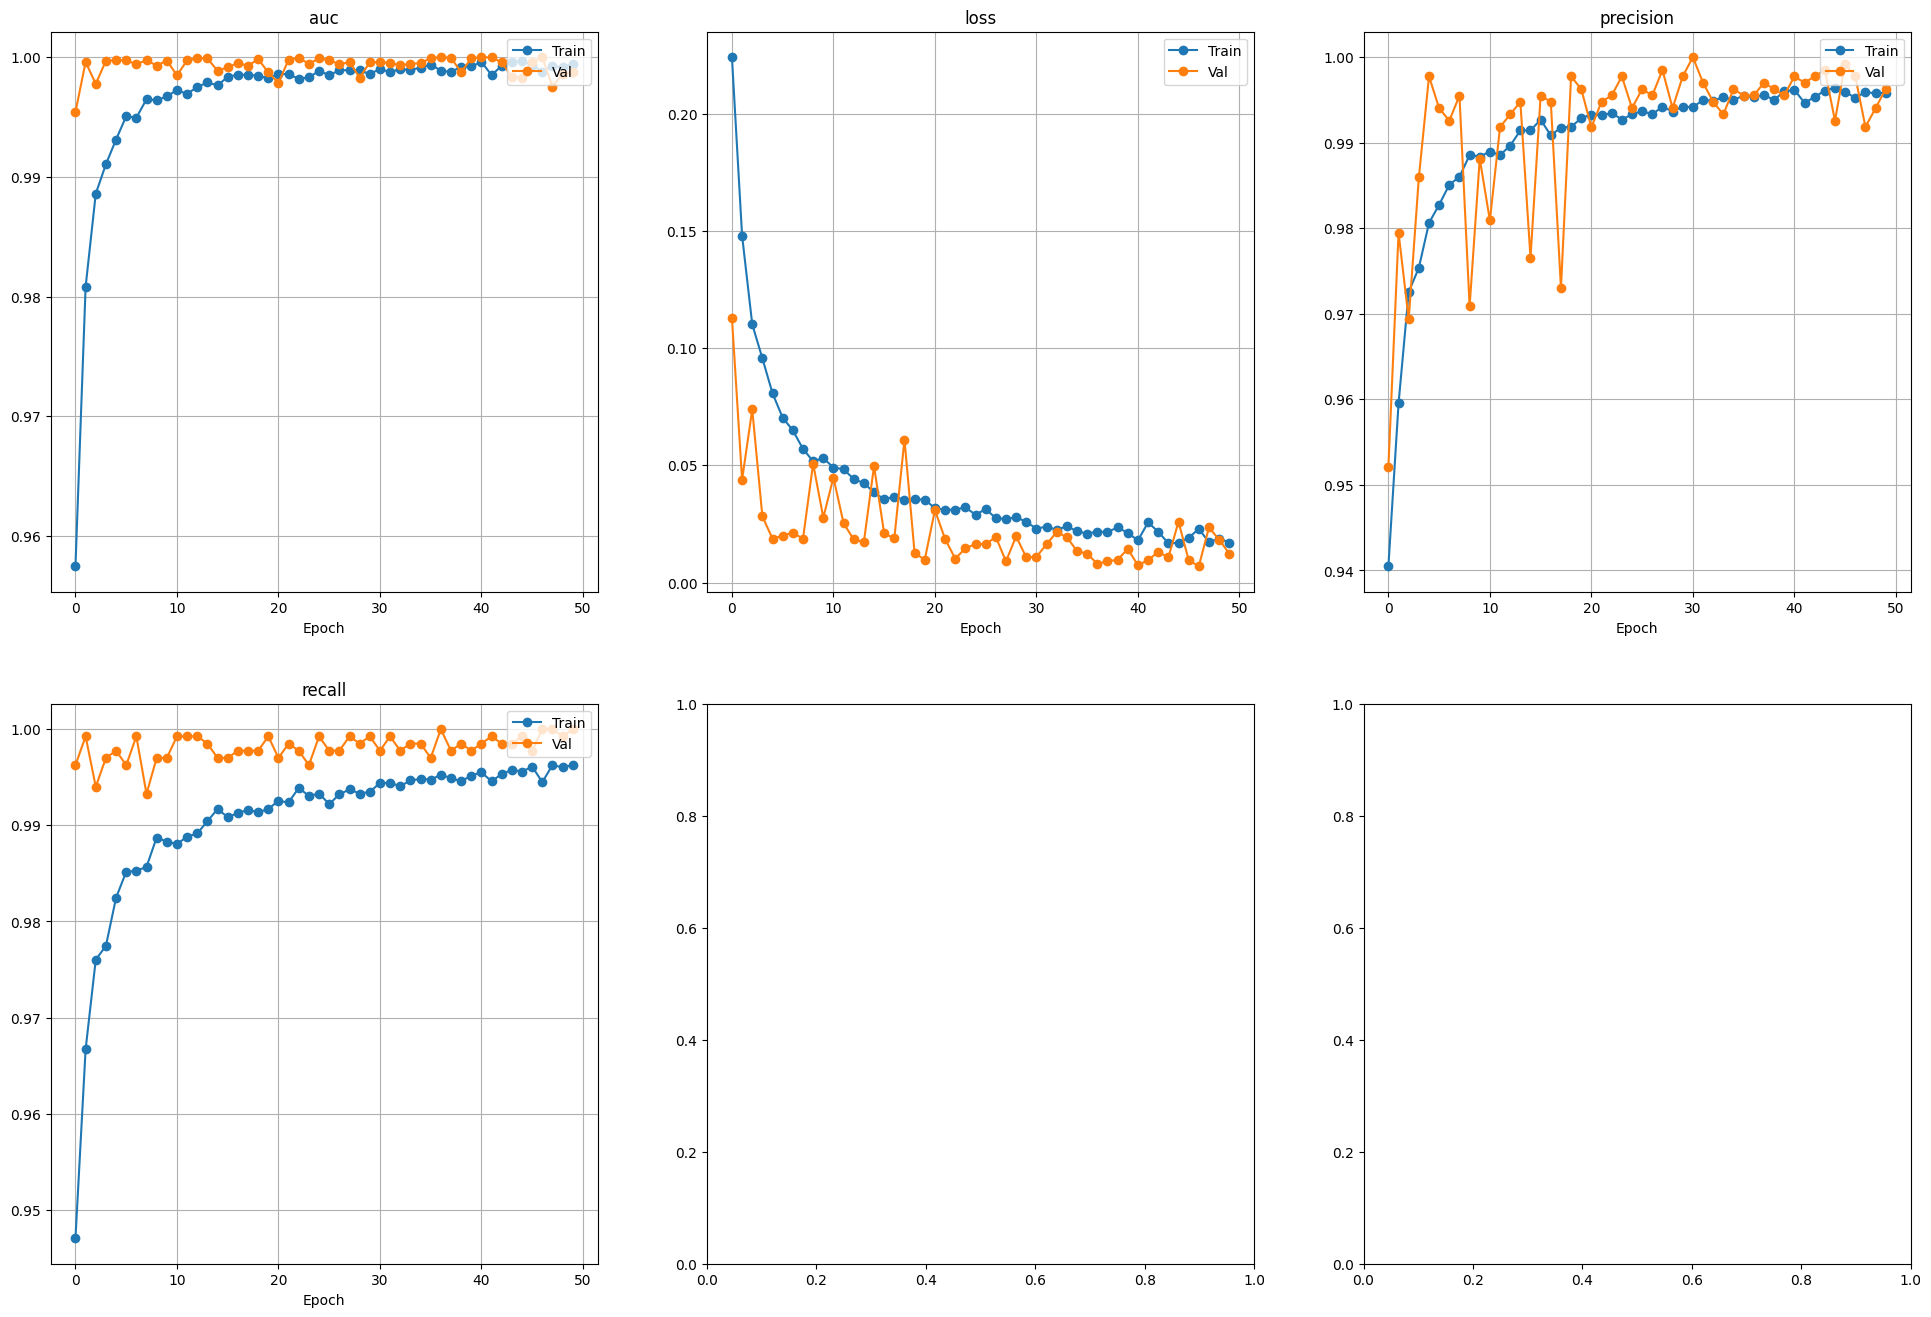

In [9]:
# Train model
history = model.fit(
    aug.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs, 
    validation_data=(X_val, y_val)
)

# Plot training history
plot_history(history.history)

In [10]:
# Load and preprocess test images
test_df = pd.DataFrame({'id': os.listdir("test/test/")}) 
X_test = prepareImages(test_df, test_df.shape[0], "test/test/", width, height, depth)

# Make predictions on test images
preds = model.predict(X_test)
preds = (preds > 0.5).astype(int)

# Save predictions to CSV
output_df = pd.DataFrame({'id': test_df['id'], 'has_cactus': preds.flatten()})
output_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")

Preparing 4000 images from aerial-cactus/test/test/ directory, resized to 32x32...
Loaded 1/4000 images
Loaded 501/4000 images
Loaded 1001/4000 images
Loaded 1501/4000 images
Loaded 2001/4000 images
Loaded 2501/4000 images
Loaded 3001/4000 images
Loaded 3501/4000 images
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predictions saved to submission.csv


# Reference
- Angrew Ng & Coursera - https://www.coursera.org/learn/machine-learning
- Anezka Kolaceke - https://www.kaggle.com/anezka/cnn-with-keras-for-humpback-whale-id
- Peter - https://www.kaggle.com/pestipeti/keras-cnn-starter
- Yassine Ghouzam, PhD - https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
- Martin Piotte - https://www.kaggle.com/martinpiotte/bounding-box-model